<a href="https://colab.research.google.com/github/afrojaakter/DeepLearningCourseWork/blob/master/Final_Project/GAN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
from skimage import color
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.constraints import min_max_norm

Import images and resize them all to the same size of 224x224 then save them for later use

In [ ]:
ImagesRaw = "/content/drive/MyDrive/resized/"
n=0
for file in os.listdir(ImagesRaw):
    image = Image.open("/content/drive/MyDrive/resized/"+file)
    array = np.asarray(image)
    gray = color.rgb2gray(array)
    resized = resize(gray,(28,28),anti_aliasing=True)
    image = Image.fromarray((resized * 255).astype(np.uint8))
    image.save("/content/drive/MyDrive/RGBPictures/"+str(n)+".jpg")
    if n%100==0:
        print(n)
    n += 1

Get image data into an array

In [ ]:
FullData = np.empty((8683,224,224),dtype=np.float32)
n=0

for file in os.listdir("/content/drive/MyDrive/ProcessedImages/"):
    image = Image.open("/content/drive/MyDrive/ProcessedImages/"+file)
    array = np.asarray(image)
    FullData[n] = array
    if n%10 == 0:
        print(n)
    n += 1 

# FullData = np.empty((8683,28,28),dtype=np.float32)
# n=0

# for file in os.listdir("/content/drive/MyDrive/RGBPictures/"):
#     image = Image.open("/content/drive/MyDrive/RGBPictures/"+file)
#     array = np.asarray(image)
#     FullData[n] = array
#     if n%10 == 0:
#         print(n)
#     n += 1 

Linearize data so that it can be saved

In [ ]:
Linearized = np.empty((8683,50176))
for pic in range(FullData.shape[0]):
    Linearized[pic] = FullData[pic].reshape((1,50176))

# Linearized = np.empty((8683,784))
# for pic in range(FullData.shape[0]):
#     Linearized[pic] = FullData[pic].reshape((1,784))

Save File

In [ ]:
np.save("/content/drive/MyDrive/PictureData.npy",Linearized,allow_pickle=False)
# np.save("/content/drive/MyDrive/SmallData.npy",Linearized,allow_pickle=False)

Load Data and reshape it into (nx224x224) array. Normalize data between 0-1 by dividing by 255

In [ ]:
Data = np.load("/content/drive/MyDrive/PictureData.npy")
Data = Data.reshape((8683,224,224,1))
Data = Data/255
TestData = Data[5000:6000]
Testy = np.ones((1000,1))
Data = Data[:5000]

# Data = np.load("/content/drive/MyDrive/SmallData.npy")
# Data = Data.reshape((8683,28,28,1))
# TestData = Data[7000:]
# Testy = np.ones((TestData.shape[0],1))
# Data = Data[:7000]
# Data = Data/255

Setup Discriminator

In [ ]:
descrim = Sequential()
descrim.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(224,224,1)))
descrim.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(256, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(256, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(512, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(512, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(1024, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Conv2D(1024, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU())
descrim.add(BatchNormalization())
descrim.add(Dropout(0.5))
descrim.add(Flatten())
descrim.add(Dense(256,activation="relu"))
descrim.add(Dense(1024,activation="relu"))
descrim.add(Dense(2048,activation="relu"))
descrim.add(Dense(1,activation='sigmoid'))

opt = Adam(lr=0.002, beta_1=0.5)
descrim.compile(loss='binary_crossentropy', optimizer=opt, metrics=["Accuracy"])
descrim.trainable = False

generate = Sequential()
generate.add(Dense(32*56*56,input_dim=500,activation="relu"))
generate.add(Reshape((56,56,32)))
# generate.add(Conv2DTranspose(64,(2,2), strides=(2,2), padding='same', activation="relu",kernel_initializer='random_uniform'))
# generate.add(BatchNormalization())
# generate.add(Conv2DTranspose(64,(4,4), strides=(2,2),padding='same', activation="relu",kernel_initializer='random_uniform'))
# generate.add(BatchNormalization())
generate.add(Conv2DTranspose(64,(4,4), strides=(2,2),padding='same', activation="relu",kernel_initializer='random_uniform'))
generate.add(BatchNormalization())
generate.add(Conv2DTranspose(1,(4,4), strides=(2,2),padding='same', activation="sigmoid",kernel_initializer='random_uniform'))

GAN = Sequential([generate,descrim])
GAN.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0005, beta_1=0.5))
# descrim.summary()
generate.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 100352)            50276352  
_________________________________________________________________
reshape_28 (Reshape)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_transpose_98 (Conv2DT (None, 112, 112, 64)      32832     
_________________________________________________________________
batch_normalization_152 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_transpose_99 (Conv2DT (None, 224, 224, 1)       1025      
Total params: 50,310,465
Trainable params: 50,310,337
Non-trainable params: 128
_________________________________________________________________


# Train the Discriminator

In [ ]:
BatchSize = 100
epochs = 2

X_train, X_test, y_train, y_test = train_test_split(Data, np.ones((Data.shape[0],1)), test_size = 0.2)
Xfakes = np.random.rand(224*224*X_test.shape[0])
Xfakes = Xfakes.reshape(X_test.shape[0],224,224,1)
yfakes = np.zeros((X_test.shape[0],1))
X_test = np.concatenate((X_test,Xfakes))
y_test = np.concatenate((y_test,yfakes))

total_iter = round(epochs*X_train.shape[0]/BatchSize)
for iter in range(total_iter):
    #Get Real Samples
    index = np.random.randint(0, X_train.shape[0], int(BatchSize/2))
    Xr = X_train[index]
    yr = y_train[index]

    #Generate Fake Samples
    Xf = np.random.rand(100*int(BatchSize/2))
    Xf = Xf.reshape((int(BatchSize/2),100))
    Xf = generate.predict(Xf)
    Xf = Xf.reshape(int(BatchSize/2),224,224,1)
    # Xf = np.random.rand(224*224*int(BatchSize/2))
    # Xf = Xf.reshape(int(BatchSize/2),224,224,1)

    yf = np.zeros((int(BatchSize/2),1))

    #Combine Sample into one array
    X = np.concatenate((Xr,Xf))
    y = np.concatenate((yr,yf))

    acc = descrim.train_on_batch(X,y)

    if iter%20 == 0:
        testacc = descrim.evaluate(X_test,y_test)

63/63 [==============================] - 0s 8ms/step - loss: 26.4303 - accuracy: 0.5000


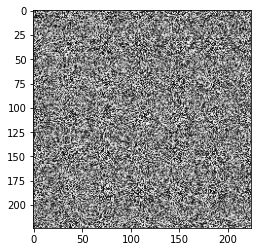

[[1.]]


In [ ]:
inputs = np.random.rand(224*224)
inputs = inputs.reshape(224,224)
inputs = inputs*255
plt.imshow(inputs,cmap="gray")
plt.show()
inputs = inputs.reshape(1,224,224,1)
print(descrim.predict(inputs))

[[120.907814 121.05768  124.968025 ... 120.59782  125.33166  141.97604 ]
 [133.13664  123.61162  133.69464  ... 121.9712   137.97832  129.38828 ]
 [118.46118  126.08045  116.930565 ... 127.303474 118.2618   157.88185 ]
 ...
 [134.17627  125.09304  134.55951  ... 122.25927  138.0211   128.98526 ]
 [119.3238   126.76747  114.01286  ... 127.8416   116.59983  157.29274 ]
 [117.04008  134.31206  113.07729  ... 135.91129  112.618515 133.25461 ]]


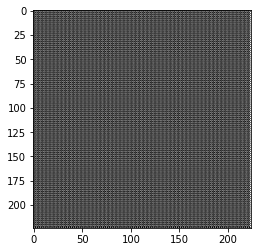

[[0.]]


In [ ]:
inputs = np.random.rand(100)
inputs = inputs.reshape(1,100)
genX = generate.predict(inputs)
genX = genX.reshape(224,224)
genX = genX*255
plt.imshow(genX,cmap="gray")
print(genX)
plt.show()
genX = genX.reshape(1,224,224,1)
print(descrim.predict(genX))

# Train the GAN

63/63 [==============================] - 1s 16ms/step - loss: 121.6702 - accuracy: 0.5000


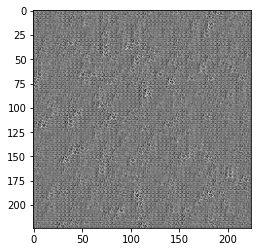

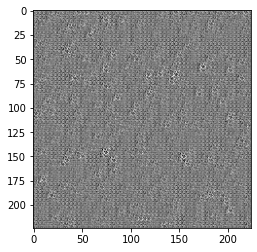

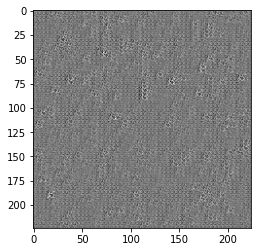

63/63 [==============================] - 1s 16ms/step - loss: 92.5031 - accuracy: 0.5000


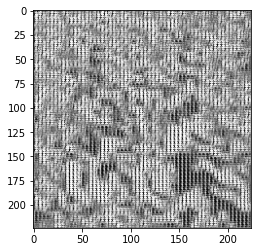

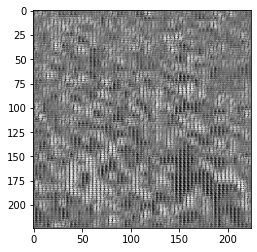

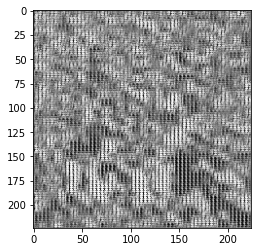

63/63 [==============================] - 1s 16ms/step - loss: 0.4356 - accuracy: 0.0000e+00


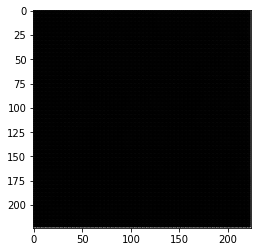

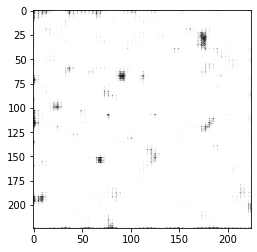

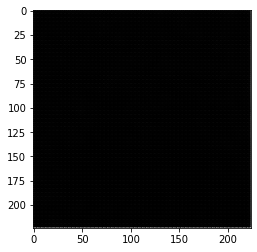

63/63 [==============================] - 1s 16ms/step - loss: 0.1893 - accuracy: 0.0000e+00


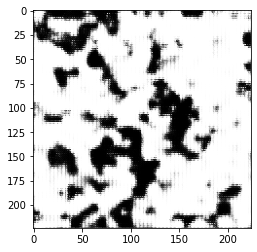

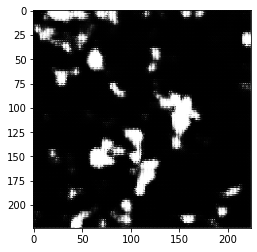

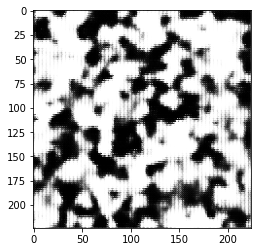

63/63 [==============================] - 1s 15ms/step - loss: 0.6554 - accuracy: 0.0000e+00


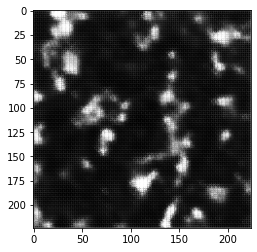

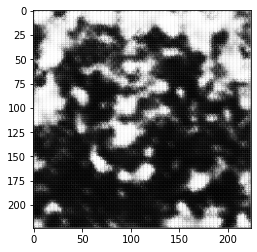

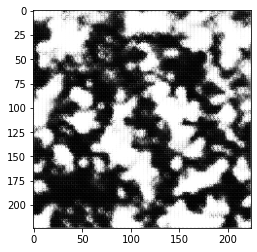

63/63 [==============================] - 1s 15ms/step - loss: 2.1508 - accuracy: 0.0000e+00


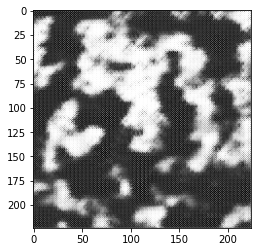

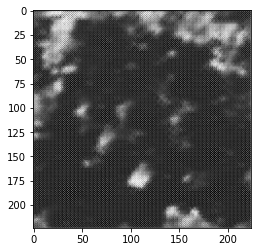

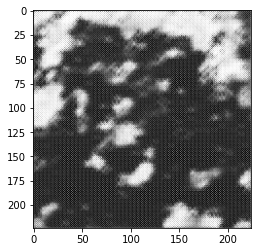

63/63 [==============================] - 1s 16ms/step - loss: 0.6937 - accuracy: 0.0000e+00


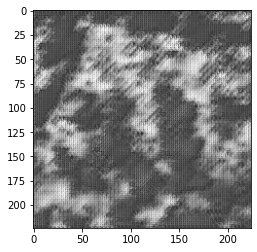

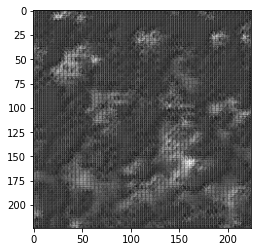

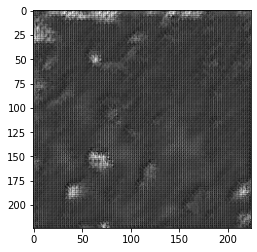

63/63 [==============================] - 1s 16ms/step - loss: 0.6662 - accuracy: 0.0000e+00


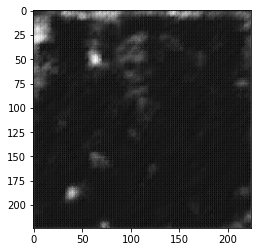

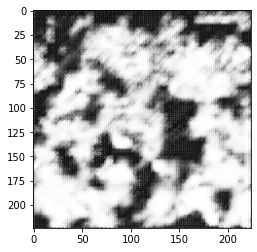

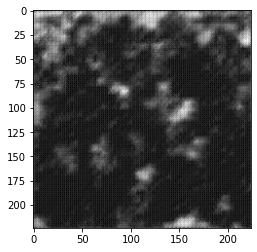

63/63 [==============================] - 1s 16ms/step - loss: 0.8374 - accuracy: 0.0000e+00


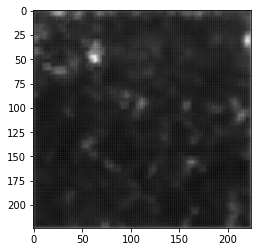

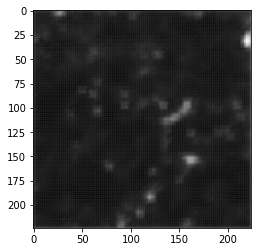

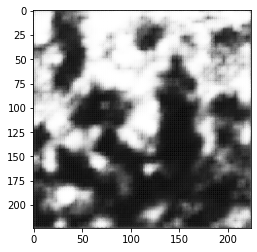

63/63 [==============================] - 1s 16ms/step - loss: 0.7185 - accuracy: 0.0000e+00


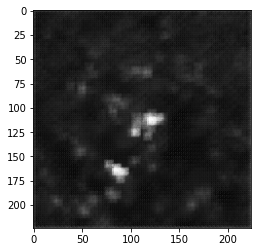

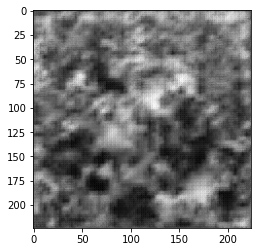

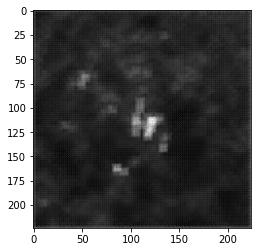

63/63 [==============================] - 1s 16ms/step - loss: 0.6706 - accuracy: 0.0000e+00


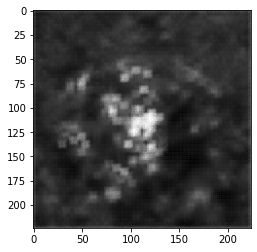

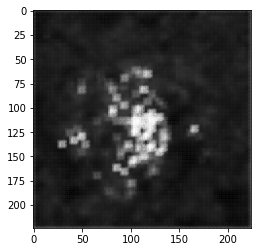

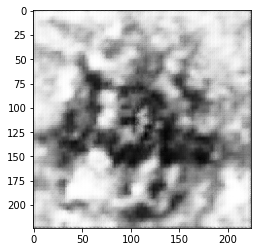

63/63 [==============================] - 1s 15ms/step - loss: 0.6882 - accuracy: 0.0000e+00


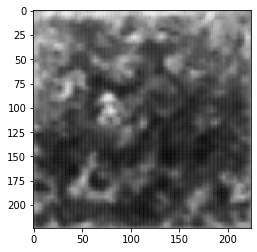

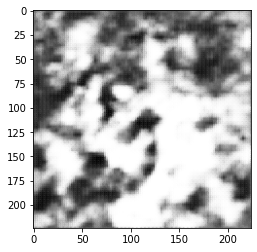

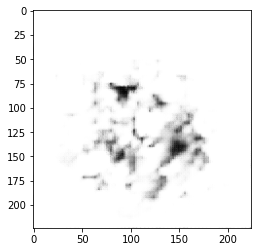

63/63 [==============================] - 1s 16ms/step - loss: 0.6929 - accuracy: 5.0000e-04


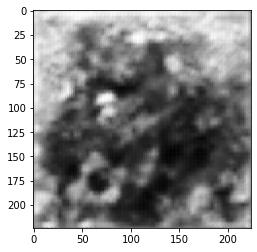

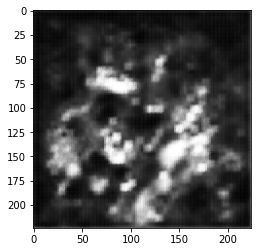

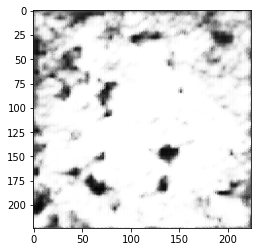

63/63 [==============================] - 1s 16ms/step - loss: 0.7096 - accuracy: 0.0000e+00


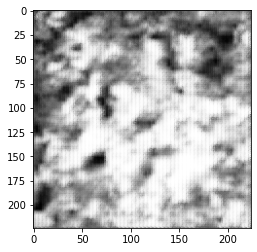

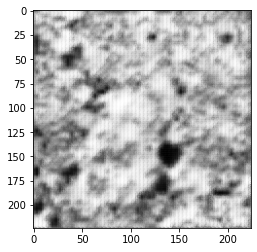

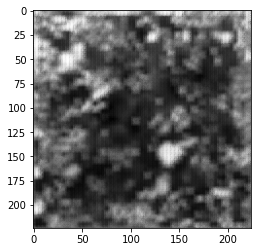

63/63 [==============================] - 1s 16ms/step - loss: 0.6700 - accuracy: 5.0000e-04


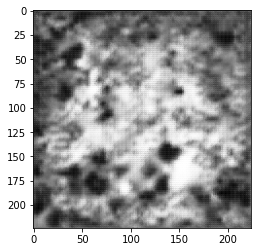

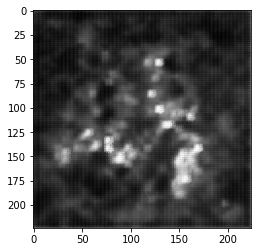

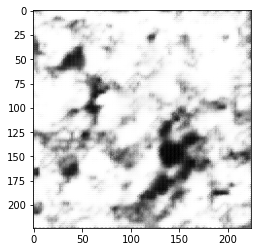

63/63 [==============================] - 1s 15ms/step - loss: 0.7126 - accuracy: 0.0000e+00


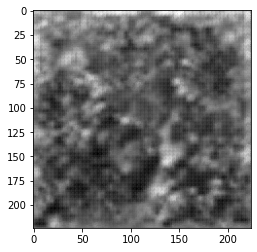

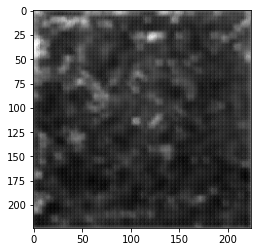

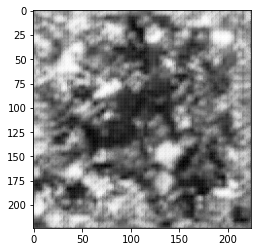

63/63 [==============================] - 1s 15ms/step - loss: 0.7205 - accuracy: 5.0000e-04


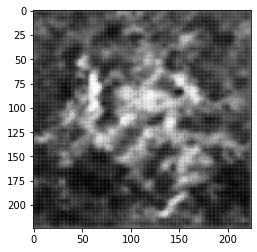

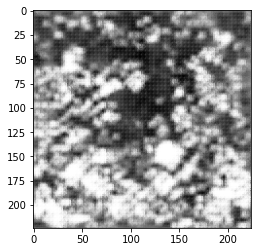

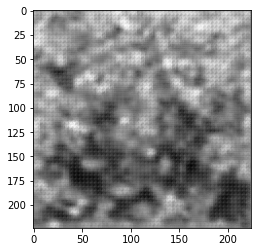

63/63 [==============================] - 1s 15ms/step - loss: 0.7046 - accuracy: 0.0000e+00


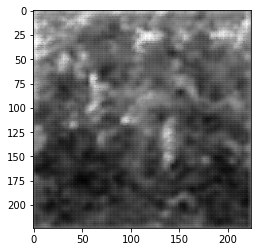

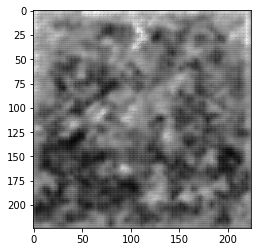

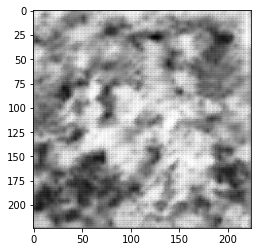

63/63 [==============================] - 1s 16ms/step - loss: 0.6917 - accuracy: 0.0000e+00


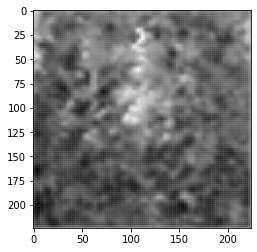

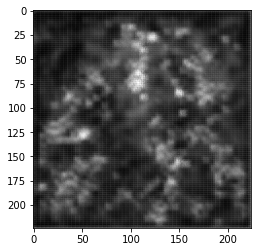

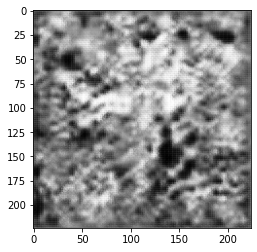

63/63 [==============================] - 1s 15ms/step - loss: 22.8179 - accuracy: 0.5000


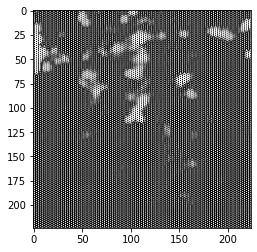

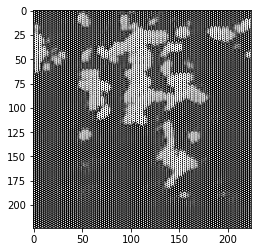

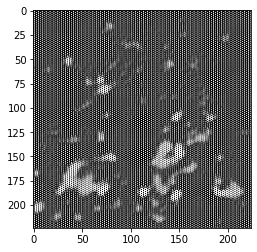

63/63 [==============================] - 1s 15ms/step - loss: 64.9925 - accuracy: 0.7000


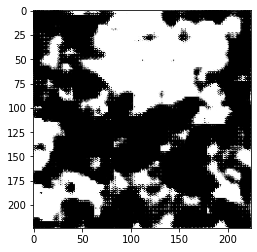

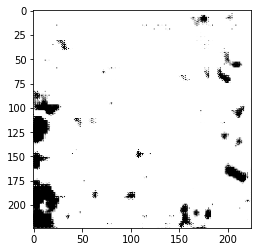

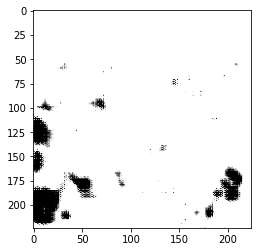

63/63 [==============================] - 1s 15ms/step - loss: 61.7880 - accuracy: 0.5290


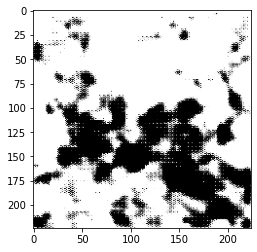

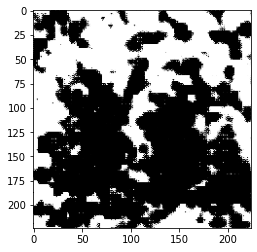

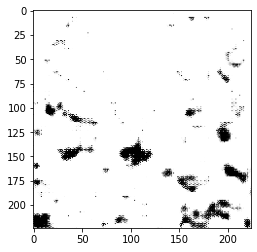

63/63 [==============================] - 1s 15ms/step - loss: 73.5391 - accuracy: 0.5035


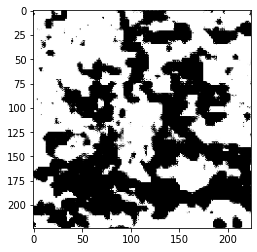

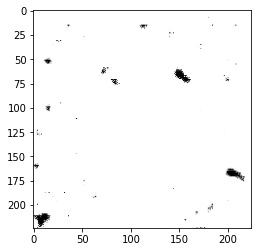

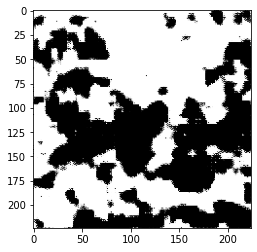

63/63 [==============================] - 1s 15ms/step - loss: 45.1770 - accuracy: 0.4975


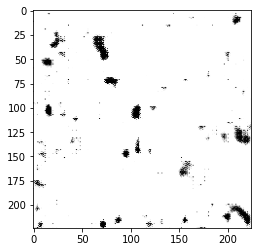

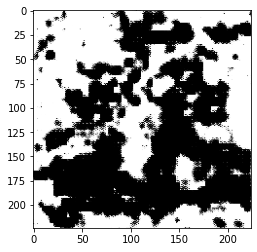

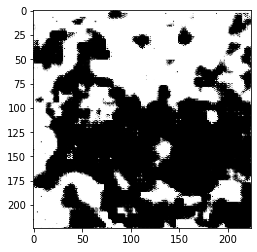

63/63 [==============================] - 1s 15ms/step - loss: 7.1704 - accuracy: 0.3375


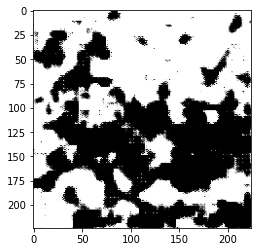

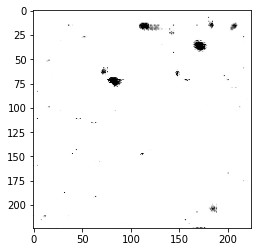

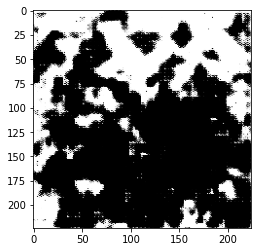

63/63 [==============================] - 1s 15ms/step - loss: 9.9524 - accuracy: 0.1645


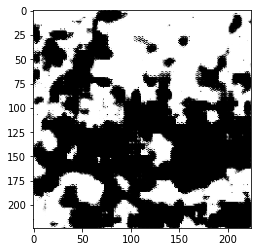

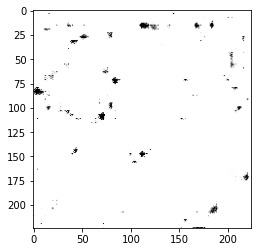

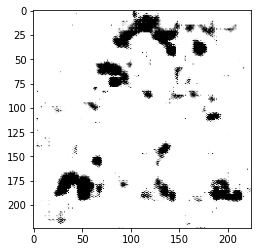

63/63 [==============================] - 1s 15ms/step - loss: 16.0722 - accuracy: 0.4610


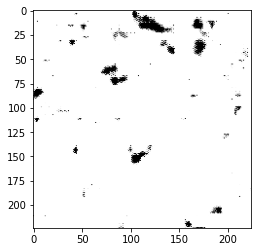

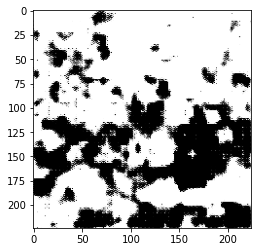

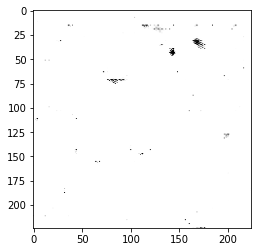

63/63 [==============================] - 1s 15ms/step - loss: 10.7105 - accuracy: 0.1005


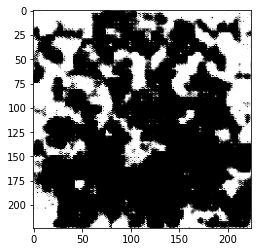

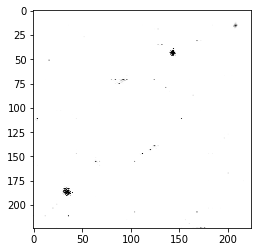

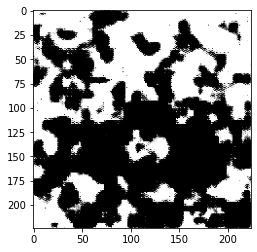

KeyboardInterrupt: ignored

In [ ]:
BatchSize = 50
epochs = 500


total_iter = round(epochs*Data.shape[0]/BatchSize)

for iter in range(total_iter):
    #Generate Fake Samples
    Xf = np.random.rand(100*int(BatchSize/2))
    Xf = Xf.reshape((int(BatchSize/2),100))
    Xf = generate.predict(Xf)
    yf = np.zeros((int(BatchSize/2),1))
    
    #Get Real Samples
    index = np.random.randint(0, Data.shape[0], int(BatchSize/2))
    Xr = Data[index]
    yr = np.ones((int(BatchSize/2),1))

    #Combine Sample into one array
    X = np.concatenate((Xr,Xf))
    y = np.concatenate((yr,yf))

    descrim.trainable = True
    for n in range(3):
        descTrain = descrim.train_on_batch(X,y)
    #descTrain = descrim.train_on_batch(X,y)

    Xf = np.random.rand(100*int(BatchSize))
    Xf = Xf.reshape((int(BatchSize),100))
    yf = np.ones((int(BatchSize),1))

    descrim.trainable = False
    GANtrain = GAN.train_on_batch(Xf,yf)

    if iter%20 == 0:
        imgs = np.random.rand(1000*100)
        imgs = imgs.reshape((1000,100))
        imgs = generate.predict(imgs)
        imgs = imgs.reshape((1000,224,224,1))
        imgsy = np.zeros((1000,1))
        TestSet = np.concatenate((TestData,imgs))
        TestSety = np.concatenate((Testy,imgsy))
        descrim.evaluate(TestSet,TestSety)
        img = imgs[:3]
        img = img.reshape((3,224,224))
        plt.imshow(img[0],cmap="gray")
        plt.show()
        plt.imshow(img[1],cmap="gray")
        plt.show()
        plt.imshow(img[2],cmap="gray")
        plt.show()

In [ ]:
descrim = Sequential()
descrim.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
descrim.add(LeakyReLU(alpha=0.2))
descrim.add(Dropout(0.4))
descrim.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
descrim.add(LeakyReLU(alpha=0.2))
descrim.add(Dropout(0.4))
descrim.add(Flatten())
descrim.add(Dense(1, activation='sigmoid'))
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
descrim.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
generate = Sequential()
# fundation for 7x7 image
n_nodes = 128 * 7 * 7
generate.add(Dense(n_nodes, input_dim=100))
generate.add(LeakyReLU(alpha=0.2))
generate.add(Reshape((7, 7, 128)))
# upsample to 14x14
generate.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generate.add(LeakyReLU(alpha=0.2))
# upsample to 28x28
generate.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generate.add(LeakyReLU(alpha=0.2))
generate.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

GAN = Sequential([generate,descrim])
GAN.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002, beta_1=0.5))

In [ ]:
generate = Sequential()
generate.add(Dense(256, input_dim=100))
generate.add(LeakyReLU(alpha=0.2))
generate.add(BatchNormalization(momentum=0.8))
generate.add(Dense(1024))
generate.add(LeakyReLU(alpha=0.2))
generate.add(BatchNormalization(momentum=0.8))
generate.add(Dense(3136))
generate.add(LeakyReLU(alpha=0.2))
generate.add(BatchNormalization(momentum=0.8))
generate.add(Reshape((56,56,1)))
generate.add(Conv2DTranspose(128, (4,4), strides=(2,2),padding="same"))
generate.add(LeakyReLU(alpha=0.2))
generate.add(BatchNormalization(momentum=0.8))
generate.add(Conv2DTranspose(1, (4,4), strides=(2,2),activation="sigmoid",padding="same"))
generate.add(Reshape((224,224,1)))

generate.summary()

descrim = Sequential()
descrim.add(Conv2D(32,(5,5),padding="same",input_shape=(224,224,1)))
descrim.add(LeakyReLU(alpha=0.2))
descrim.add(MaxPool2D(padding="same"))
# descrim.add(Conv2D(64,(5,5),padding="same"))
# descrim.add(LeakyReLU(alpha=0.2))
# descrim.add(BatchNormalization(momentum=0.8))
# descrim.add(Conv2D(64,(3,3),padding="same"))
# descrim.add(LeakyReLU(alpha=0.2))
# descrim.add(BatchNormalization(momentum=0.8))
descrim.add(Flatten())
descrim.add(Dense(16))
descrim.add(LeakyReLU(alpha=0.2))
descrim.add(Dense(32))
descrim.add(LeakyReLU(alpha=0.2))
descrim.add(Dense(64))
descrim.add(LeakyReLU(alpha=0.2))
descrim.add(Dense(1, activation='sigmoid'))
descrim.summary()
descrim.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01, beta_1=0.5),metrics=["Accuracy"])
descrim.trainable = False

GAN = Sequential([generate,descrim])
GAN.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.005, beta_1=0.5))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              3